## Sandbox

Required modules can be installed with `pip`:
~~~
pip install -r requirements-dev.txt
~~~

### Inspect Input Data

We assume that the input data (i.e. mesh) has a well-defined format and can be converted a 2d raster grid.

In [1]:
files = ["data/mesh.json", "data/mesh_x_sin_cos_10000.json", "data/mesh_x_sin_cos_20000.json"]

In [2]:
import json
import view_spot_finder.finder

for p in files:
  with open(p) as f:
    mesh = json.load(f)
    view_spot_finder.finder.validate_mesh_grid(mesh)

### Visualize Input Data

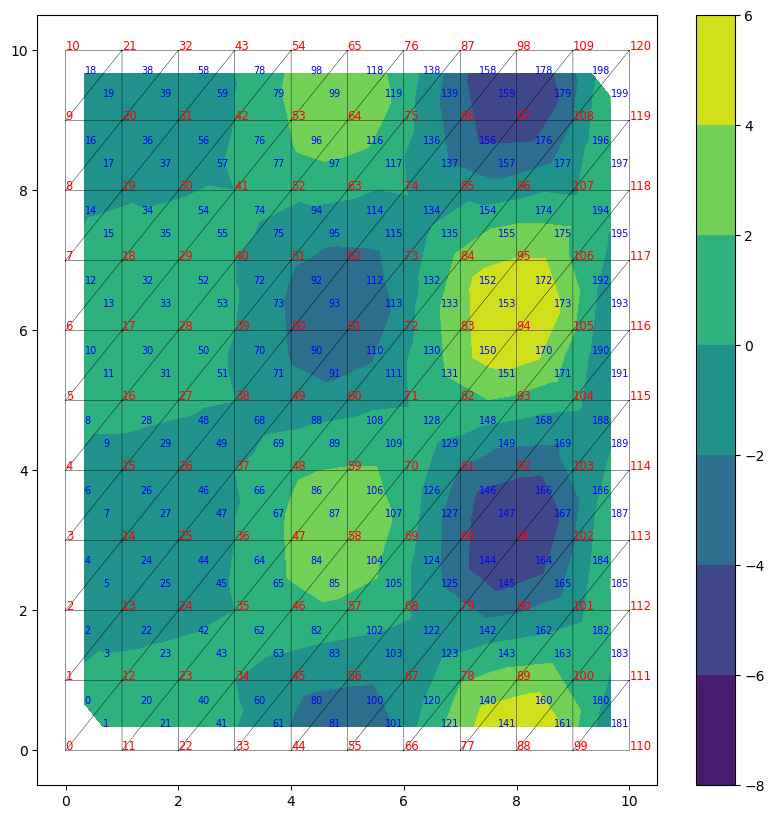

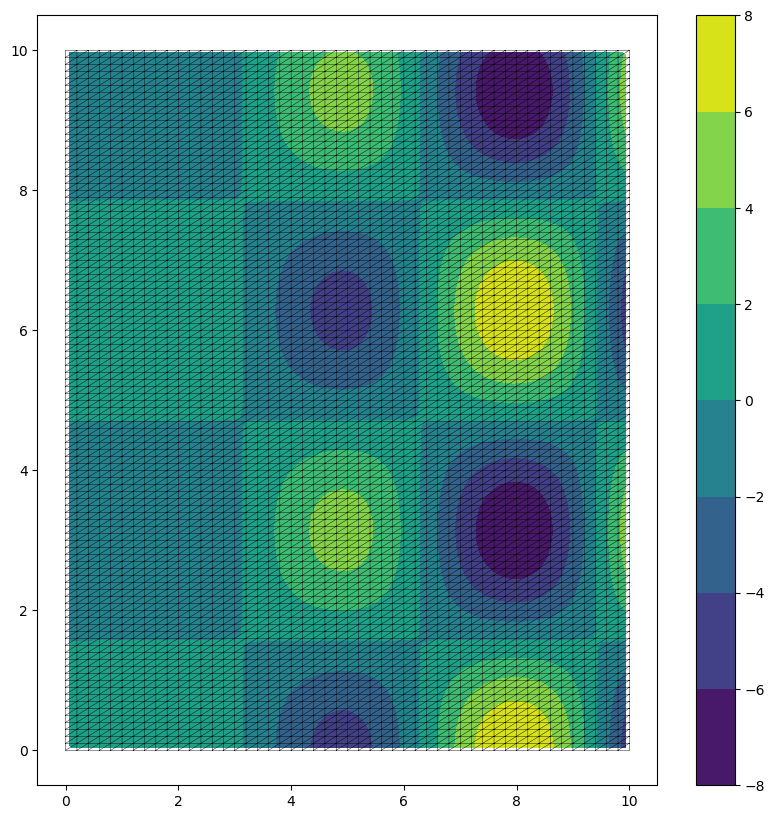

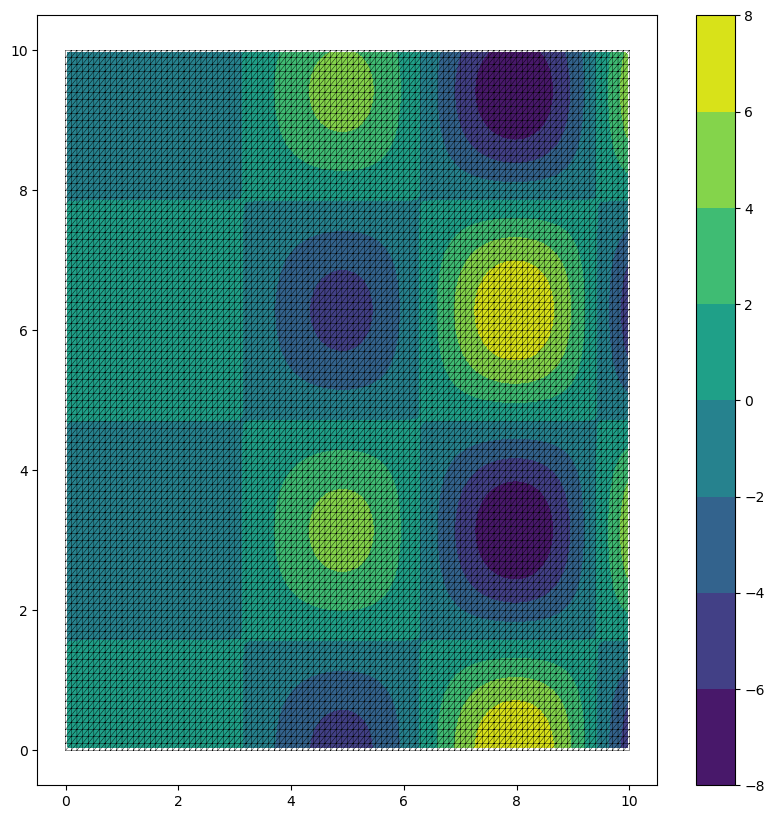

In [3]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import json
  
for p in files:
  with open(p) as f:
    mesh = json.load(f)
    elements = mesh['elements']
    nodes = mesh['nodes']
    values = mesh['values']

    fig = plt.figure(figsize=(10, 10))

    # approximation: show height in color
    new_nodes = []
    for tri in values:
      element_id = tri['element_id']
      element = elements[element_id]
      ia, ib, ic = element['nodes']
      node_a, node_b, node_c = nodes[ia], nodes[ib], nodes[ic]
      new_nodes.append(
        [(node_a["x"] + node_b["x"] + node_c["x"])/3.0,
         (node_a["y"] + node_b["y"] + node_c["y"])/3.0])
    xy = np.array(new_nodes)
    x, y = xy[:,0], xy[:,1]
    triang = mtri.Triangulation(x, y)
    z = [v['value'] for v in values]
    p = plt.tricontourf(x, y, z, zorder=1)
    fig.colorbar(p)

    # show meshes
    xy = [[e['x'], e['y']] for e in nodes]
    xy = np.array(xy)
    x, y  = xy[:,0], xy[:,1]
    triangles = [e['nodes'] for e in elements]
    triang = mtri.Triangulation(x, y, triangles)
    plt.triplot(triang, 'k-', lw=0.3, zorder=2)

    # show text in case of just few nodes
    if len(nodes) < 300:
      for n in nodes:
        plt.text(n['x'], n['y'], "%d"%n['id'], size="small", color="red", zorder=3)
      for e in elements:
        id = e["id"]
        ia, ib, ic = e["nodes"]
        node_a, node_b, node_c = nodes[ia], nodes[ib], nodes[ic]
        _x = (node_a["x"] + node_b["x"] + node_c["x"])/3.0
        _y = (node_a["y"] + node_b["y"] + node_c["y"])/3.0
        plt.text(_x, _y, "%d"%id, size="x-small", color="blue", zorder=3)

    plt.show()

### Scale a mesh down to a simple raster grid

The elements of a mesh will be down-sampled.

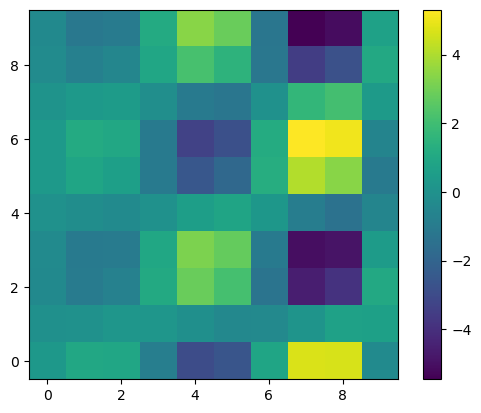

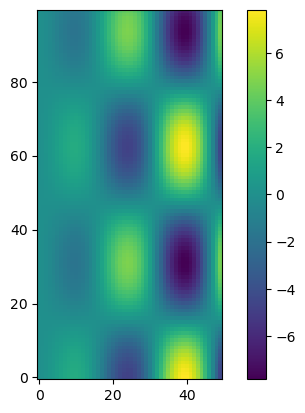

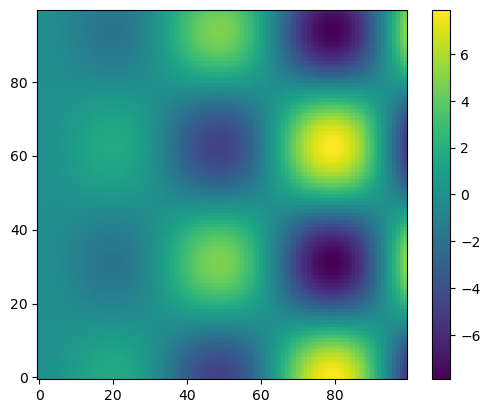

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import view_spot_finder.finder

for p in files:
  with open(p) as f:
    mesh = json.load(f)
    grid = view_spot_finder.finder.scale_to_grid(mesh)
    fig = plt.figure()
    # swap axis to have better visual comparision
    p = plt.imshow(np.swapaxes(grid,0,1), interpolation='none', origin='lower')
    fig.colorbar(p)
    plt.show()

### Find Local Maxima

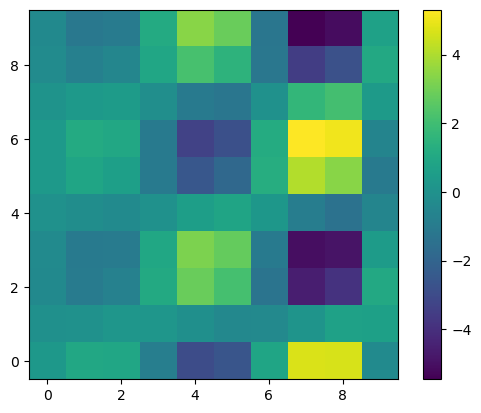

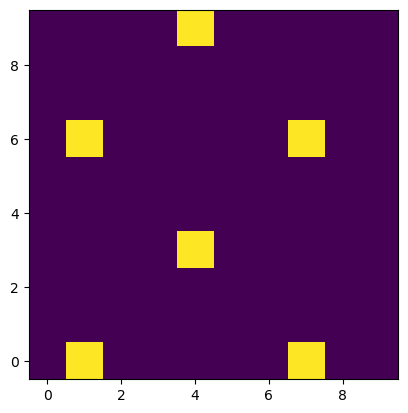

Peak [x,y]: [[1, 0], [1, 6], [4, 3], [4, 9], [7, 0], [7, 6]]


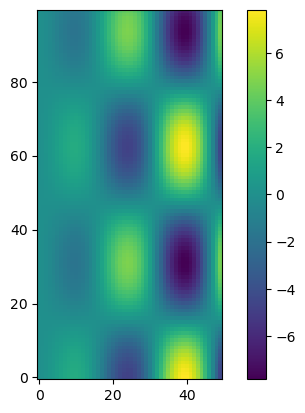

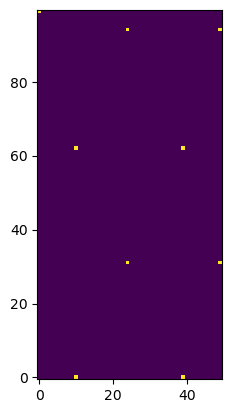

Peak [x,y]: [[0, 99], [10, 0], [10, 62], [24, 31], [24, 94], [39, 0], [39, 62], [49, 31], [49, 94]]


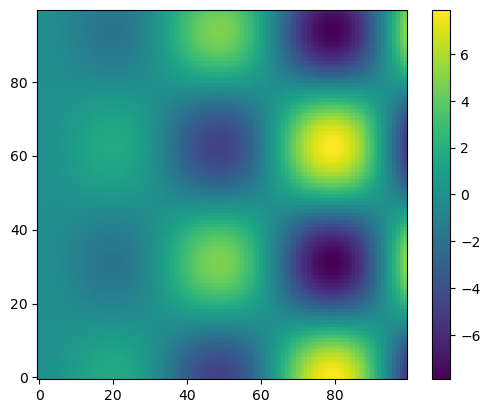

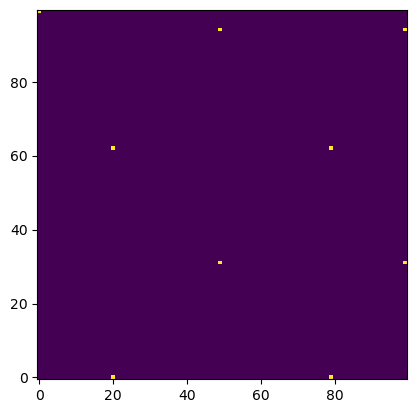

Peak [x,y]: [[0, 99], [20, 0], [20, 62], [49, 31], [49, 94], [79, 0], [79, 62], [99, 31], [99, 94]]


In [7]:
import numpy as np
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
import view_spot_finder.finder

# Some nice articles:
# https://stackoverflow.com/questions/56148387/finding-image-peaks-using-ndimage-maximum-filter-and-skimage-peak-local-max
# https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array?noredirect=1&lq=1

for p in files:
  with open(p) as f:
    mesh = json.load(f)
    grid = view_spot_finder.finder.scale_to_grid(mesh)
    grid = np.array(grid)

    fig = plt.figure() 
    p = plt.imshow(np.swapaxes(grid,0,1), interpolation='none', origin='lower')
    fig.colorbar(p)

    # local maxima
    local_max = maximum_filter(grid, size=(4,4), mode="nearest") == grid
    plt.figure() 
    plt.imshow(np.swapaxes(local_max,0,1), interpolation='none', origin='lower')
    plt.show()
    print("Peak [x,y]:", np.swapaxes(np.nonzero(local_max), 0, 1).tolist())
    ##